In [80]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onlineretail/OnlineRetail.csv


In [81]:
# --------------------------------------
# MSCS-634-B01 | Lab 6: Association Rule Mining
# --------------------------------------

# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings("ignore")

In [82]:
# Step 2: Load and Clean Data
df = pd.read_csv('/kaggle/input/onlineretail/OnlineRetail.csv', encoding='ISO-8859-1')

In [83]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [84]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [85]:
df = df.drop(columns=['CustomerID'])

In [86]:
# Drop missing values
df.dropna(subset=['Description'], inplace=True)

In [87]:
# Only consider positive quantity transactions
df = df[df['Quantity'] > 0]

In [88]:
# Step 3: Prepare Transaction Dataset
basket = (df
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Convert quantities to 1 (presence) and 0 (absence)
basket_sets = basket.applymap(lambda x: 1 if x >= 1 else 0)

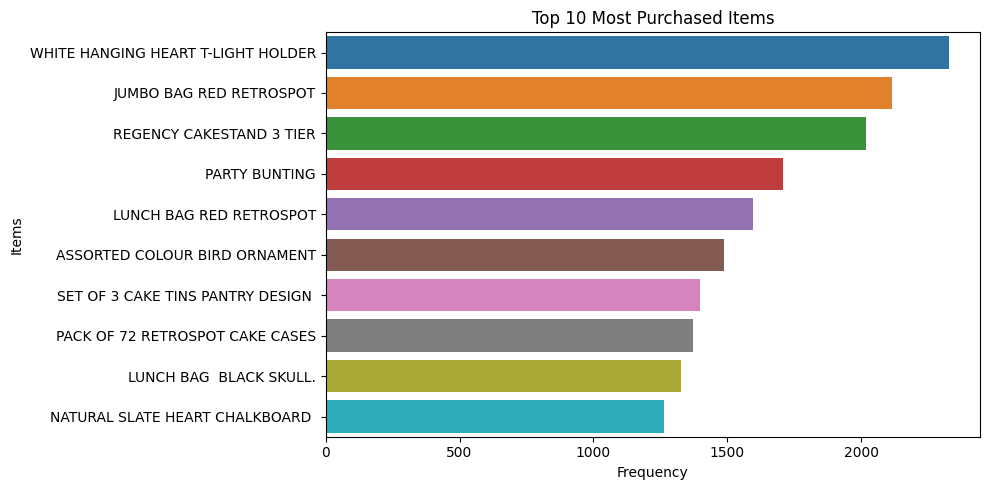

In [89]:
# Step 4: Visualize Top Items
item_counts = df['Description'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=item_counts.values, y=item_counts.index)
plt.title("Top 10 Most Purchased Items")
plt.xlabel("Frequency")
plt.ylabel("Items")
plt.tight_layout()
plt.show()

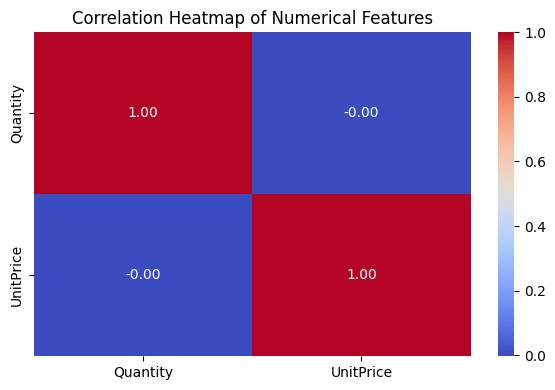

In [90]:
# Select numerical features
numerical_features = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Display the correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

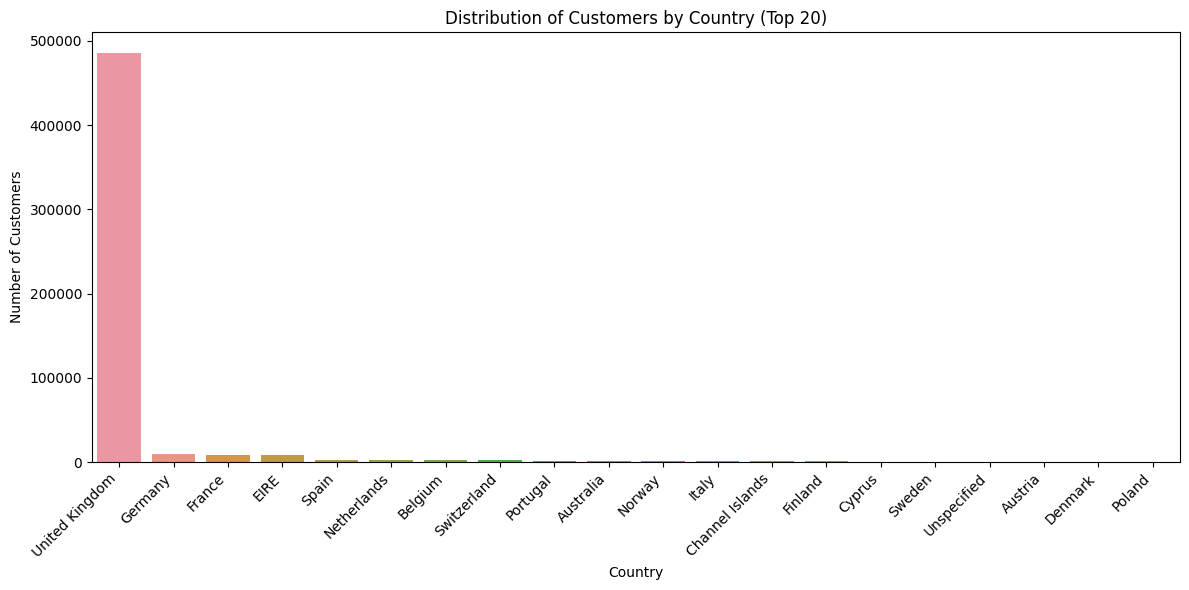

In [91]:
# Count occurrences of each country
country_counts = df['Country'].value_counts().head(20)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title('Distribution of Customers by Country (Top 20)')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [92]:
# Step 5: Frequent Itemset Mining with Apriori
start = time.time()
frequent_itemsets_apriori = apriori(basket_sets, min_support=0.02, use_colnames=True)
end = time.time()
print(f"Apriori - Time taken: {end - start:.2f}s")
frequent_itemsets_apriori.sort_values(by='support', ascending=False).head()

Apriori - Time taken: 7.15s


,support,itemsets
273,0.112237,(WHITE HANGING HEART T-LIGHT HOLDER)
102,0.103894,(JUMBO BAG RED RETROSPOT)
197,0.098778,(REGENCY CAKESTAND 3 TIER)
157,0.083731,(PARTY BUNTING)
127,0.077672,(LUNCH BAG RED RETROSPOT)


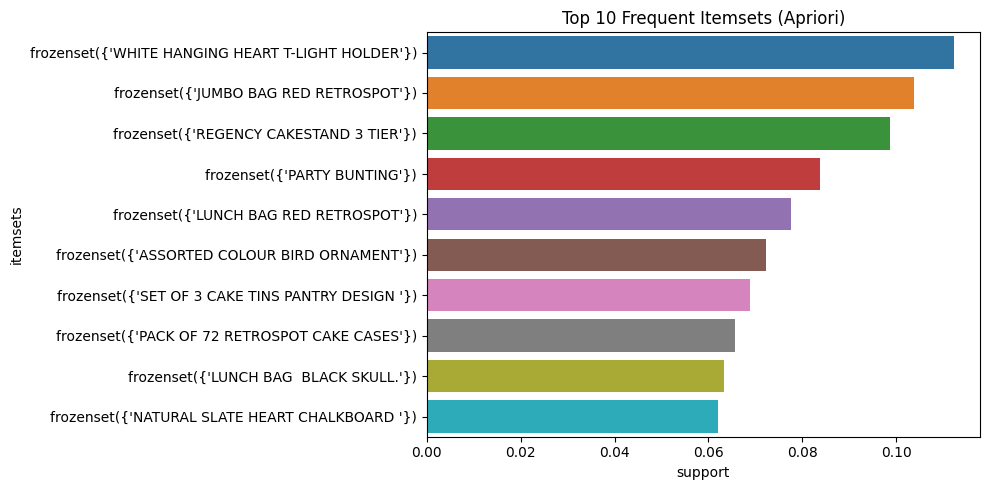

In [93]:
# Visualize top itemsets
plt.figure(figsize=(10, 5))
sns.barplot(x='support', y='itemsets', data=frequent_itemsets_apriori.nlargest(10, 'support'))
plt.title("Top 10 Frequent Itemsets (Apriori)")
plt.tight_layout()
plt.show()

In [94]:
# Step 6: Frequent Itemset Mining with FP-Growth
start = time.time()
frequent_itemsets_fpgrowth = fpgrowth(basket_sets, min_support=0.02, use_colnames=True)
end = time.time()
print(f"FP-Growth - Time taken: {end - start:.2f}s")
frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head()

FP-Growth - Time taken: 8.18s


,support,itemsets
0,0.112237,(WHITE HANGING HEART T-LIGHT HOLDER)
66,0.103894,(JUMBO BAG RED RETROSPOT)
162,0.098778,(REGENCY CAKESTAND 3 TIER)
232,0.083731,(PARTY BUNTING)
29,0.077672,(LUNCH BAG RED RETROSPOT)


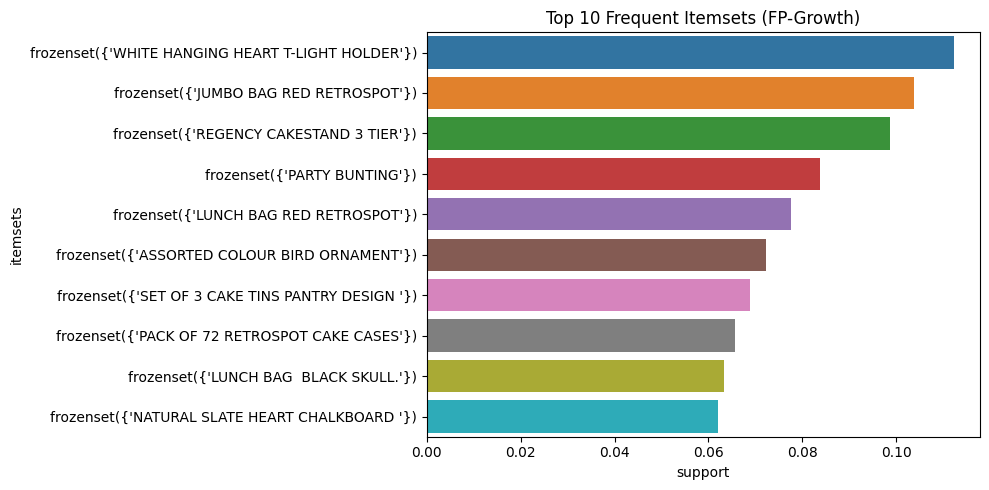

In [95]:
# Visualize top itemsets
plt.figure(figsize=(10, 5))
sns.barplot(x='support', y='itemsets', data=frequent_itemsets_fpgrowth.nlargest(10, 'support'))
plt.title("Top 10 Frequent Itemsets (FP-Growth)")
plt.tight_layout()
plt.show()

In [96]:
# Step 7: Association Rule Mining
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.3)
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.3)

print("Apriori - Rules Summary:")
rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

Apriori - Rules Summary:


,antecedents,consequents,support,confidence,lift
0,(PACK OF 72 RETROSPOT CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.022497,0.343182,8.345784
1,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETROSPOT CAKE CASES),0.022497,0.547101,8.345784
2,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.020759,0.533844,10.968864
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.020759,0.426531,10.968864
4,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.031784,0.608944,12.511932


In [97]:
print("\nFP-Growth - Rules Summary:")
rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


FP-Growth - Rules Summary:


,antecedents,consequents,support,confidence,lift
0,(JAM MAKING SET PRINTED),(JAM MAKING SET WITH JARS),0.023441,0.406196,7.219035
1,(JAM MAKING SET WITH JARS),(JAM MAKING SET PRINTED),0.023441,0.416593,7.219035
2,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.031784,0.608944,12.511932
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.031784,0.653061,12.511932
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED ),0.023341,0.600255,11.500231


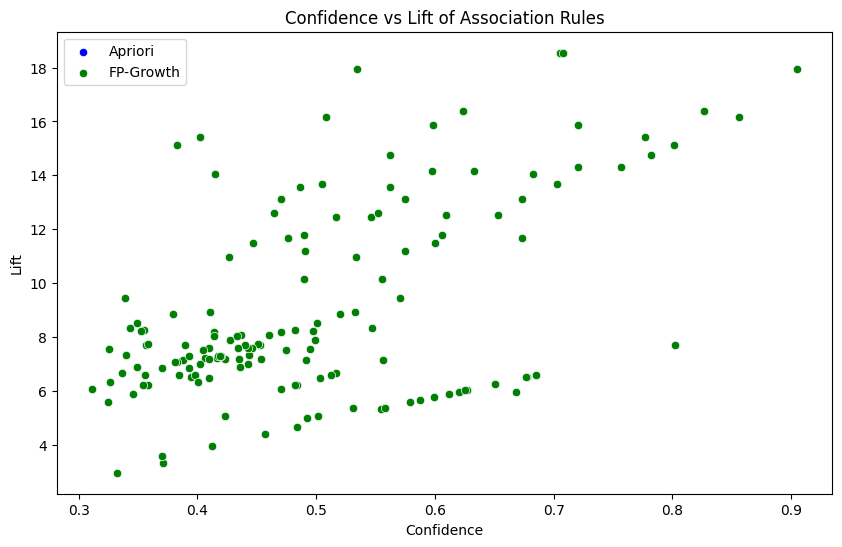

In [98]:
# Visualize rules (confidence vs lift)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules_apriori, x='confidence', y='lift', label='Apriori', color='blue')
sns.scatterplot(data=rules_fpgrowth, x='confidence', y='lift', label='FP-Growth', color='green')
plt.title("Confidence vs Lift of Association Rules")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.legend()
plt.show()

In [99]:
# Step 8: Comparative Analysis
print("\nComparative Analysis:")
print(f"Apriori: {len(frequent_itemsets_apriori)} frequent itemsets")
print(f"FP-Growth: {len(frequent_itemsets_fpgrowth)} frequent itemsets")
print(f"Apriori generated {len(rules_apriori)} rules")
print(f"FP-Growth generated {len(rules_fpgrowth)} rules")
print("\nFP-Growth is generally faster and more scalable on larger datasets, while Apriori is easier to understand but slower due to candidate generation.")


Comparative Analysis:
Apriori: 375 frequent itemsets
FP-Growth: 375 frequent itemsets
Apriori generated 151 rules
FP-Growth generated 151 rules

FP-Growth is generally faster and more scalable on larger datasets, while Apriori is easier to understand but slower due to candidate generation.
